In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import random
%matplotlib inline

In [7]:
# --- Load test set & model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_test = datasets.MNIST(root="./data", train=False, download=False, transform=transform)

# --- Image Stitching ---
def stitch_and_resize(images, labels, out_size=256, min_scale=1.25, max_scale=1.75):
    images = images.squeeze(1)
    labels = torch.tensor(labels)
    N = len(images)

    canvas = torch.zeros((out_size, out_size), dtype=images.dtype, device=images.device)
    occupied_mask = torch.zeros((out_size, out_size), dtype=torch.bool, device=images.device)
    centers = []

    max_attempts = 200
    for i in range(N):
        scale = random.uniform(min_scale, max_scale)
        orig_digit_size = images[i].shape[-1]
        new_digit_size = int(orig_digit_size * scale)
        new_digit_size = max(8, min(new_digit_size, out_size))  # avoid too small or too big
        digit_resized = TF.resize(images[i].unsqueeze(0), [new_digit_size, new_digit_size]).squeeze(0)
        
        placed = False
        for _ in range(max_attempts):
            x = random.randint(0, out_size - new_digit_size)
            y = random.randint(0, out_size - new_digit_size)
            region = occupied_mask[y:y+new_digit_size, x:x+new_digit_size]
            if not region.any():
                canvas[y:y+new_digit_size, x:x+new_digit_size] = digit_resized
                occupied_mask[y:y+new_digit_size, x:x+new_digit_size] = True
                center_x = x + new_digit_size // 2
                center_y = y + new_digit_size // 2
                centers.append((center_x, center_y, labels[i].item()))
                placed = True
                break
        if not placed:
            raise RuntimeError(f"Could not place digit {i} after {max_attempts} attempts. Try fewer digits.")

    # Improved row grouping (same as before)
    centers = sorted(centers, key=lambda t: t[1])  # sort by y
    rows = []
    row = [centers[0]]
    row_height_thresh = int(28 * 0.8)  # you can set this relative to orig digit size or avg new size
    for c in centers[1:]:
        avg_y = sum([d[1] for d in row]) / len(row)
        if abs(c[1] - avg_y) <= row_height_thresh:
            row.append(c)
        else:
            rows.append(row)
            row = [c]
    if row:
        rows.append(row)

    rows = sorted(rows, key=lambda r: sum([d[1] for d in r]) / len(r))
    centers_ordered = []
    for row in rows:
        row_sorted = sorted(row, key=lambda t: t[0])
        centers_ordered.extend(row_sorted)
    sorted_labels = torch.tensor([label for _, _, label in centers_ordered], dtype=labels.dtype, device=labels.device)
    stitched = canvas.unsqueeze(0)
    return stitched, sorted_labels


# --- Custom Dataset ---
class CustomMNISTDataset(torch.utils.data.Dataset):
    """ Custom Dataset for MNIST that stitches a given number of images together """
    def __init__(self, mnist_dataset, length=60000):
        self.mnist_dataset = mnist_dataset
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Get N random images and their labels
        num = torch.randint(1, 11, (1,)).item()  # Randomly choose between 1 and 10
        idxs = torch.randint(0, len(self.mnist_dataset), (num,)) # Random indices
        # Get images and labels from the dataset
        imgs, labels = zip(*(self.mnist_dataset[i.item()] for i in idxs))
        images = torch.stack(imgs)
        stitched_image, stitched_label = stitch_and_resize(images, labels)
        stitched_label = torch.cat([stitched_label, torch.tensor([11], device=stitched_label.device, dtype=stitched_label.dtype)])
        return stitched_image, stitched_label

# --- Patch Embedding ---
class PatchEmbed(nn.Module):
    """ Patch Embedding Layer for Vision Transformer
    Args:"""
    def __init__(self, patch_size=16, embed_dim=64, img_size=256, in_chans=1):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.proj = nn.Linear(patch_size * patch_size * in_chans, embed_dim)

    def forward(self, x):
        # x: (B, 1, 256, 256)
        B, C, H, W = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        # patches: (B, C, num_patches_h, num_patches_w, patch_size, patch_size)
        patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        # patches: (B, C, num_patches, patch_size, patch_size)
        patches = patches.permute(0, 2, 1, 3, 4)  # (B, num_patches, C, 16, 16)
        patches = patches.reshape(B, self.num_patches, -1)  # (B, num_patches, patch_size*patch_size*C) / (B, 256, 256)
        return self.proj(patches)  # (B, 256, embed_dim)
    
# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x):
        x_res1 = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x)
        x = x + x_res1

        x_res2 = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = x + x_res2
        return x

# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.masked_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln3 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x, enc_out, mask):
        x_res1 = x
        x = self.ln1(x)
        x, _ = self.masked_attn(x, x, x, attn_mask=mask)
        x = x + x_res1

        x_res2 = x
        x, _ = self.cross_attn(x, enc_out, enc_out)

        x = self.ln2(x)
        x = x + x_res2

        x_res3 = x
        x = self.mlp(x)
        x = x + x_res3
        return x
    
# --- Visual Transformer ---
class VisualTransformer(nn.Module):
    def __init__(self, patch_size, embed_dim, num_heads, num_layers, num_classes, img_size=256, in_chans=1, seq_len=11):
        super().__init__()
        self.patch_embed = PatchEmbed(patch_size, embed_dim, img_size, in_chans)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.pos_encod_enc = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_encod_enc, std=0.02)

        self.encoder = nn.ModuleList([EncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.seq_len = seq_len
        self.vocab_size = num_classes + 3   # +1 for start token
        self.tok_embed = nn.Embedding(self.vocab_size, embed_dim)
        self.pos_encod_dec = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        nn.init.trunc_normal_(self.pos_encod_dec, std=0.02)

        self.decoder = nn.ModuleList([DecoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.linear = nn.Linear(embed_dim, self.vocab_size)


    def forward(self, x, y):
        # x: (B, 1, 256, 256)
        B = x.shape[0]
        x = self.patch_embed(x)                        # (B, 256, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, 257, embed_dim)
        x = x + self.pos_encod_enc                     # (B, 257, embed_dim)
        for block in self.encoder:
            x = block(x)
        x = self.norm(x)                               # (B, 257, embed_dim)

        # y: (B, seq_len)
        y = self.tok_embed(y)                                 # (B, seq_len, embed_dim)
        curr_seq_len = y.shape[1]
        pos_encod_dec = self.pos_encod_dec[:, :curr_seq_len, :].expand(B, curr_seq_len, -1)
        y = y + pos_encod_dec                           # (B, seq_len, embed_dim)
        mask = torch.triu(torch.ones((curr_seq_len, curr_seq_len), device=x.device), diagonal=1).bool()
        for block in self.decoder:
            y = block(y, x, mask=mask)      # (B, seq_len, embed_dim)
        out = self.linear(y)                # (B, seq_len, vocab_size)
        return out

def evaluate(model, data_loader):
    model.eval()
    correct_tokens, total_tokens = 0, 0
    correct_seqs, total_seqs = 0, 0
    pad_token = 12
    eos_token = 11
    start_token = 10

    with torch.no_grad():
        for x, y, y_lens in data_loader:
            x, y = x.to(device), y.to(device)
            B, seq_len = y.shape

            # Greedy decoding with start token
            y_input = torch.full((B, 1), start_token, dtype=torch.long, device=device)
            preds = []

            for t in range(seq_len):
                out = model(x, y_input)  # (B, t+1, vocab_size)
                next_token = out[:, -1, :].argmax(dim=-1, keepdim=True)  # (B, 1)
                preds.append(next_token)
                y_input = torch.cat([y_input, next_token], dim=1)
                # Optional: break if all seqs have EOS (can add optimization)

            preds = torch.cat(preds, dim=1)  # (B, seq_len)

            # --- Per-token accuracy: ignore PAD in target ---
            mask = (y != pad_token)
            correct_tokens += (preds[mask] == y[mask]).sum().item()
            total_tokens += mask.sum().item()

            # --- Per-sequence accuracy (all tokens up to EOS or PAD must match) ---
            for i in range(B):
                # Get reference (ground truth) up to EOS or PAD
                gt_seq = []
                for tok in y[i].tolist():
                    if tok == eos_token or tok == pad_token:
                        break
                    gt_seq.append(tok)
                # Get prediction up to EOS or PAD
                pred_seq = []
                for tok in preds[i].tolist():
                    if tok == eos_token or tok == pad_token:
                        break
                    pred_seq.append(tok)
                # Compare full sequence
                if pred_seq == gt_seq:
                    correct_seqs += 1
                total_seqs += 1

    token_acc = 100 * correct_tokens / total_tokens if total_tokens else 0
    seq_acc = 100 * correct_seqs / total_seqs if total_seqs else 0

    print(f"Token Accuracy: {token_acc:.2f}% | Sequence Accuracy: {seq_acc:.2f}%")
    return token_acc, seq_acc

def collate_fn(batch):
    x_seqs, y_seqs = zip(*batch)
    y_lens = [y.shape[0] for y in y_seqs]
    x_batch = torch.stack(x_seqs)
    y_padded = pad_sequence(y_seqs, batch_first=True, padding_value=12)
    return x_batch, y_padded, y_lens

@torch.no_grad()
def infer(model, img_tensor, seq_len=11, device='cpu'):
    img_tensor = img_tensor.unsqueeze(0).to(device)  # shape (1, 1, 256, 256)
    start_token = 10
    y_input = torch.full((1, 1), start_token, dtype=torch.long, device=device)
    preds = []
    for _ in range(seq_len):
        logits = model(img_tensor, y_input)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        next_digit = next_token.item()
        if next_digit == 11:
            break
        preds.append(next_digit)
        y_input = torch.cat([y_input, next_token], dim=1)
    return preds


In [8]:

# --- Load model ---
model = VisualTransformer(
    patch_size=16,
    embed_dim=64,
    num_heads=4,
    num_layers=4,
    num_classes=10,
    img_size=256,
    seq_len=11,
).to(device)
model.load_state_dict(torch.load('mnist_vit_multi_final.pth', map_location=device))
model.eval()

# Print total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

test_dataset_stitch = CustomMNISTDataset(mnist_test, length=5000)
test_loader_stitch = DataLoader(test_dataset_stitch, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

Total parameters:     503,063
Trainable parameters: 503,063


True sequence: [1 2 3 9 3 6 8 8]
Predicted sequence: [1, 2, 3, 9, 6, 3, 8, 8]


(-0.5, 255.5, 255.5, -0.5)

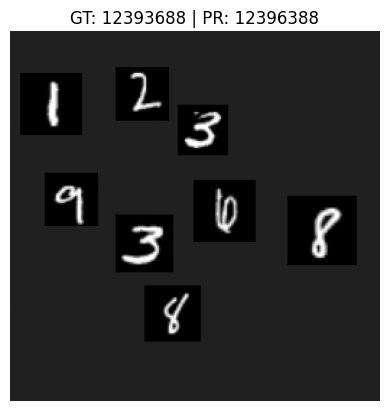

In [9]:
# --- Qualitative test (repeat as desired) ---
num_digits = random.randint(2, 8)   # You can set this to any number in [1,10]
sample_idxs = random.sample(range(len(mnist_test)), num_digits)
images = torch.stack([mnist_test[i][0] for i in sample_idxs])
labels = [mnist_test[i][1] for i in sample_idxs]

stitched_img, true_labels = stitch_and_resize(images, labels, out_size=256)
preds = infer(model, stitched_img, seq_len=11, device=device)

print("True sequence:", true_labels.cpu().numpy())
print("Predicted sequence:", preds)

plt.imshow(stitched_img.squeeze().cpu().numpy(), cmap="gray")
plt.title(f"GT: {''.join(str(x) for x in true_labels.cpu().numpy())} | PR: {''.join(str(x) for x in preds)}")
plt.axis('off')

In [10]:
evaluate(model, test_loader_stitch)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.12/3.12.10_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.12/3.12.10_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
               ^^^^ ^    ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^
^^^^^  File "/usr/local/Cellar/python@3.12/3.12.10_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
^^^^^^^^^^
  File "/usr/local/Cellar/python@3.12/3.12.10_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^

RuntimeError: DataLoader worker (pid(s) 14659) exited unexpectedly